In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [ ]:
def undistort_img():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('chessboard/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('chessboard/cal_pickle.p', 'wb') )

def undistort(img, cal_dir='chessboard/cal_pickle.p'):
    #cv2.imwrite('camera_cal/test_cal.jpg', dst)
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [ ]:
undistort_img()

Text(0.5, 1.0, 'Undistorted Image')

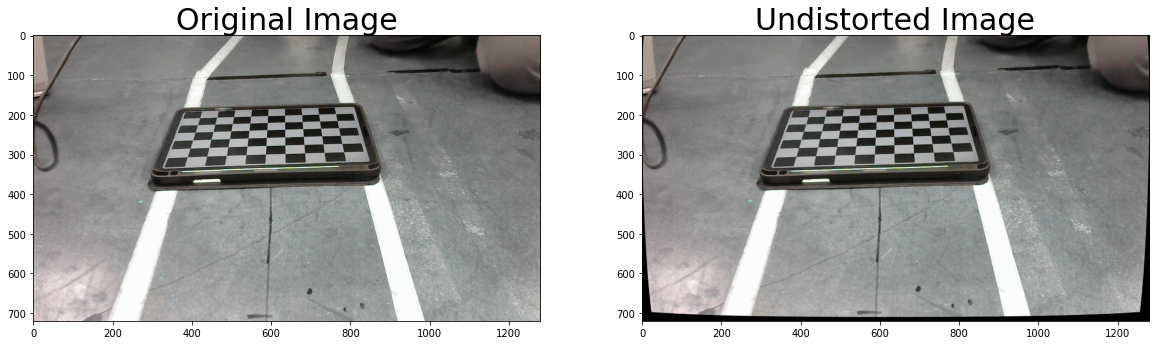

In [ ]:
img = cv2.imread('adudu/WIN_20230405_14_43_09_Pro.jpg')
distort = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(distort)
ax2.set_title('Undistorted Image', fontsize=30)


Text(0.5, 1.0, 'Undistorted Image')

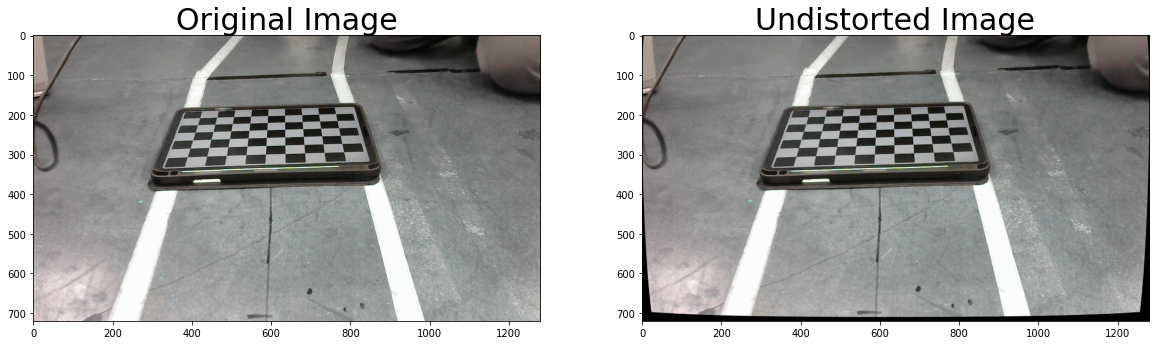

In [ ]:
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
def perspective_warp(img, src, dst):
    img_size = (1280,720)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

def inv_perspective_warp(img, src, dst):
    img_size = (1280,720)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped



In [ ]:
def point_warp(point, M):
    # convert the point to homogeneous coordinates
    homo = np.array([point[0], point[1], 1]).reshape(-1, 1)
    # apply perspective transform to the point
    warped_point_homo = M @ homo
    warped_point = (warped_point_homo[:2] / warped_point_homo[2]).astype(int)
    return warped_point

def point_unwarp(point, M):
    #inverse back
    M_inv = np.linalg.inv(M)
    point_original_homog = M_inv @ point
    point_original = (point_original_homog[:2] / point_original_homog[2]).astype(int)
    return point_original


Text(0.5, 1.0, 'Warped Image')

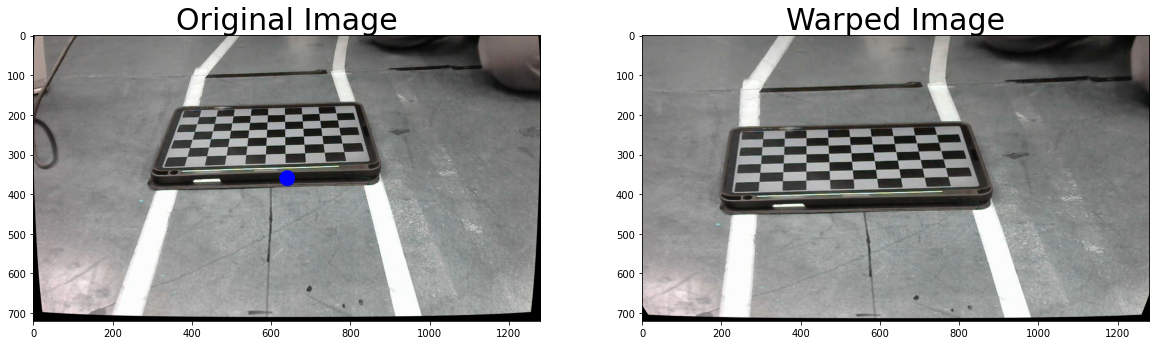

In [ ]:
# img = cv2.imread('adudu/WIN_20230404_21_28_04_Pro.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#dst = pipeline(img)
                    #  src=np.float32([(0,0), (1230, 0), (0,720), (1230,720)]),
                    #  dst=np.float32([(400,0),(950,0),(200,720),(1200,720)]))

height = img.shape[0]
width = img.shape[1]

src_ref=np.float32([(250,0),(1150,0),(0,720),(1280,720)])
dst_ref=np.float32([(0,0), (1280, 0), (0,720), (1280,720)])

M = cv2.getPerspectiveTransform(src_ref, dst_ref)
warp = perspective_warp(distort, src_ref, dst_ref)

center_point = (int(width/2), int(height/2))

cv2.circle(distort, center_point, 5, (0, 0, 255), 30)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distort)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warp, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

In [ ]:
def calculate_ratio(warp):
    CHESSBOARD_CORNER_NUM_X = 9
    CHESSBOARD_CORNER_NUM_Y = 6
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    gray = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        #Draw and display the corners
        cv2.drawChessboardCorners(warp, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
    x1, y1 = corners2[0][0]
    x2 = corners2[53][0]
    y2 = corners2[8][0]
    y_square_pixel = cv2.norm(y1 - y2)/10

    x_square_pixel = cv2.norm(x1 - x2)/10
    square_mm = 22.28 #mm
    x_pixel_per_mm = x_square_pixel / square_mm
    y_pixel_per_mm = y_square_pixel / square_mm

    return (x_pixel_per_mm, y_pixel_per_mm)